In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [21]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

In [22]:
def benchmark_CI(M, Mhat, k, idxs_calib, idxs_test, alpha, allow_inf = True, verbose = True):
    n_test_queries = len(idxs_test[0])//k
    n_calib = len(idxs_calib[0])
    alpha_corrected = alpha / k
    
    if verbose:
        print("Computing prediction intervals with Bonferroni correction with alpha {} for {} test queries...".format(alpha, n_test_queries))

    residuals = np.abs(M - Mhat)
    residual_calib = residuals[idxs_calib]

    est = np.array(Mhat[idxs_test])
    
    level_corrected = (1 - alpha_corrected) * (1 + 1/n_calib)
    if level_corrected >= 1:
        is_inf = np.ones(n_test_queries)
        if allow_inf:
            lower = np.repeat(-np.inf, len(idxs_test[0]))
            upper = np.repeat(np.inf, len(idxs_test[0]))
        else:
            lower = est - np.max(residual_calib)
            upper = est + np.max(residual_calib)
    else:
        is_inf = np.zeros(n_test_queries)
        qnt = np.quantile(residual_calib, level_corrected, method="higher")
        lower = est - qnt
        upper = est + qnt

    if verbose:
        print("Done!")
        
    return lower, upper, is_inf

In [33]:
# Matrix shape and rank
n1, n2 = 100,100
k = 5
r = 3
prop_obs = 0.2
random_state = 1
allow_inf = False

In [37]:
sampler = QuerySampling(n1,n2)

# Split observation mask and test mask
mask_obs, mask_test = sampler.sample_submask(sub_size=prop_obs, random_state=random_state)

# Sample calibration queries 
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, random_state=random_state)

# Sample test queries
n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), 50)
_, idxs_test, _ = sampler.sample_train_calib(mask_test, k, calib_size=n_test_queries, random_state=random_state)

In [38]:
# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

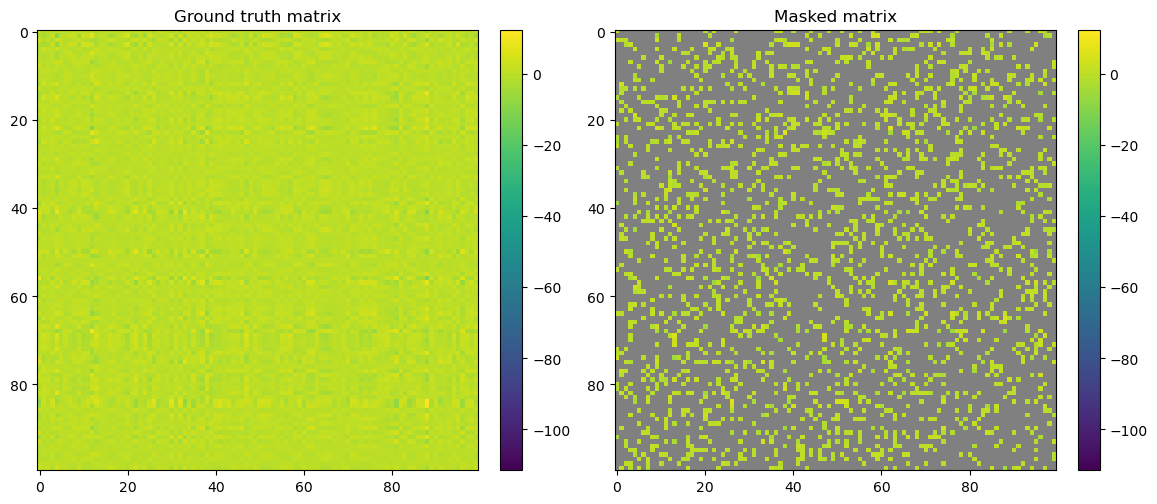

Missing entries are masked in grey.
Observation size: 2000, training size: 1095, calib size: 905, calib queries: 181, test queries: 50


In [39]:
assert np.all(mask_train+mask_calib==mask_obs),'Sampling error!'
vmin, vmax = np.min(M)-100, np.max(M)
plot_before_after_mask(M, mask_obs, vmin, vmax)
print("Missing entries are masked in grey.")
print("Observation size: {}, training size: {}, calib size: {}, calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

In [40]:
def noisy_oracle(M, a=1, b=1, gamma=0.9, random_state=0):
    rng = np.random.default_rng(random_state)
    
    n1, n2 = M.shape
    
    # Generate noise with beta distribution, each row has the same residual 
    row_residual = rng.beta(a,b,n1)
    residual = np.transpose(np.tile(row_residual, (n2,1)))
    residual /= np.max(residual)     # normalize
     
    # Generate gaussian noise independent at each entry
    noise = rng.normal(0,1,M.shape)
    noise /= np.max(np.abs(noise))   # normalize
    
    # add a tunning parameter to control the correlation within entries in each row
    Mhat = M + gamma*residual + (1-gamma)*noise
    
    return Mhat

In [41]:
# Toggle gamma to see the row wise correlation
Mhat =  noisy_oracle(M, a=1, b=10, gamma=0.99, random_state= random_state)

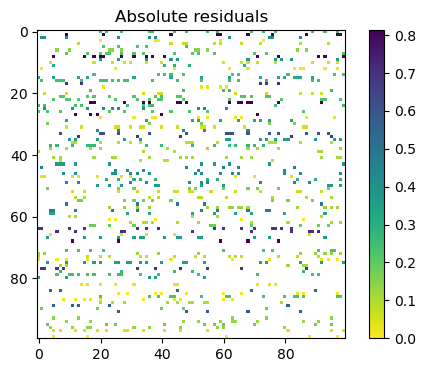

In [42]:
# some rows have larger residuals
error_heatmap(M, Mhat, mask_calib)

In [389]:
alpha=0.1
sci = SimulCI(M, Mhat, mask_obs, idxs_calib, k)

In [390]:
df = sci.get_CI(idxs_test, alpha)

Computing conformal prediction intervals for 50 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]

Done!


In [391]:
res = evaluate_SCI(df.loc[0].lower, df.loc[0].upper, k, M, idxs_test, df.loc[0].is_inf, method="SCI")

In [392]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.98,0.98,1.370576,0.0,SCI


In [43]:
test=mask_calib

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [393]:
# Sample calibration queries 
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k=1, calib_size=np.sum(mask_calib), random_state=random_state)

In [318]:
bm = Bonf_benchmark(M, Mhat, mask_obs, idxs_calib_bm, k)

In [319]:
alpha = [0.1, 0.1*k]

In [320]:
df_bon = bm.get_CI(idxs_test, alpha)

Computing Bonferroni-style intervals for 50 test queries...


CI: 100%|████████████████████████████████████████████████████████████████████████████| 250/250 [03:02<00:00,  1.37it/s]

Done!


In [322]:
df_bon

,alpha,lower,upper,is_inf
0,0.1,"[-0.6932126752038404, -0.4858416354976196, -0....","[0.45952925614190654, 0.6669002958481274, 0.81...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.5,"[-0.2907432565539293, -0.08337221684770846, 0....","[0.057059837491995405, 0.26443087719821623, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [323]:
res_uncorrected = evaluate_SCI(df_bon.loc[1].lower, df_bon.loc[1].upper, k, M, idxs_test, df_bon.loc[1].is_inf, method="Uncorrected")

In [324]:
res_uncorrected

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.94,0.948,0.347803,0.0,Uncorrected


In [325]:
res_bon = evaluate_SCI(df_bon.loc[0].lower, df_bon.loc[0].upper, k, M, idxs_test, df_bon.loc[0].is_inf, method="Bonferroni")

In [326]:
pd.concat([res_uncorrected, res,res_bon])

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.94,0.948,0.347803,0.0,Uncorrected
0,0.92,0.924,0.273235,0.0,SCI
0,0.98,0.996,1.152742,0.0,Bonferroni


In [394]:
lower, upper, is_inf = benchmark_CI(M, Mhat, k, idxs_calib_bm, idxs_test, 0.1, allow_inf = True, verbose = True)

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 50 test queries...
Done!


In [395]:
res_test = evaluate_SCI(lower,upper, k, M, idxs_test, is_inf, method="Bonferroni")
res_test

,Query_coverage,Coverage,Size,Inf_prop,Method
0,1.0,1.0,1.626092,0.0,Bonferroni


In [396]:
lower, upper, is_inf = benchmark_CI(M, Mhat, k, idxs_calib, idxs_test, 0.1, allow_inf = True, verbose = True)

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 50 test queries...
Done!


In [397]:
res_test = evaluate_SCI(lower,upper, k, M, idxs_test, is_inf, method="Bonferroni")
res_test

,Query_coverage,Coverage,Size,Inf_prop,Method
0,1.0,1.0,1.585401,0.0,Bonferroni


In [46]:
for i, m in enumerate(["Bonferroni", "Uncorrected"]):
    print(i,m)

0 Bonferroni
1 Uncorrected


In [85]:
# Header for results file
def add_header(df):
    df["n1"] = n1
    df["n2"] = n2
    df['alpha'] = alpha
    df['r_true'] = r_true
    df['r_guess'] = r_guess
    df['gamma_n'] = gamma_n
    df['gamma_m'] = gamma_m
    df['noise_model'] = noise_model
    
    if noise_model == "step":
        df['mu'] = mu
    else:
        df['a'] = a
        df['b'] = b   
    return df


def run_single_experiment(M_true, alpha, k, size_obs, n_calib_queries, max_test_queries, 
                          r_true, r_guess, gamma_n=0, gamma_m=0, noise_model='beta', a=1, b=1, mu=1,
                          random_state=0):    
    res = pd.DataFrame({})
    
    #-------Generate masks----------#
    #-------------------------------#
    n1, n2 = M_true.shape
    sampler = QuerySampling(n1,n2)
    mask_obs, mask_test = sampler.sample_submask(size_obs, random_state=random_state)
    mask_train, idxs_calib, _ = sampler.sample_train_calib(mask_obs, n_calib_queries, k, random_state)

    
    #-------Sample test queries-------#
    #-------------------------------#
    n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), max_test_queries)
    _, idxs_test, _ = sampler.sample_train_calib(mask_test, n_test_queries, k, random_state=random_state)
    
    if verbose:
        print("Training size:{}, calib size: {}, test size: {}\n".format(np.sum(mask_train), n_calib_queries, n_test_queries))
        sys.stdout.flush()
    
    
    #--------Generate noise---------#
    #-------------------------------#
    nm = NoiseModel(random_state)
    M = nm.get_noisy_matrix(M_true, gamma_n=gamma_n, gamma_m=gamma_m, model=noise_model, 
                            a=a, b=b, mu=mu, alpha=alpha, normalize=False)
    
    
    #--------Model Training---------#
    #-------------------------------#
    print("Running matrix completion algorithm on the splitted training set...")
    sys.stdout.flush()
    if solver == "pmf":
        Mhat, _, _ = pmf_solve(M, mask_train, k=r_guess, verbose=verbose, random_state=random_state)
    elif solver == "svt":
        Mhat = svt_solve(M, mask_train, verbose = verbose, random_state = random_state)
    print("Done training!\n")
    sys.stdout.flush()
    
    
    #------Conformal methods--------# 
    #-------------------------------#
    for method in methods:
        
        is_inf = np.zeros(n_test_queries)
        if method == "conformal":
            sci = SimulCI(M, Mhat, mask_obs, idxs_calib, k)
            lower, upper, is_inf, _ = sci.get_CI(idxs_test, alpha, allow_inf=allow_inf)
        elif method == "naive":
            sci = SimulCI(M, Mhat, mask_obs, idxs_calib, k)
            lower, upper, is_inf = sci.naive_CI(idxs_test, alpha, allow_inf=allow_inf)       
        elif method == "bonferroni":
            lower, upper, is_inf = benchmark_CI(M, Mhat, k, idxs_calib, idxs_test, alpha, allow_inf=allow_inf)
        else:
            lower, upper, is_inf = benchmark_CI(M, Mhat, k, idxs_calib, idxs_test, k * alpha, allow_inf=allow_inf)
        
        res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf, method=method)])
    
    res['k'] = k
    res['Calib_size'] = n_calib_queries
    res['Train_size'] = np.sum(mask_train)
    res['Test_size'] = n_test_queries
    res['random_state'] = random_state
    return res

In [107]:
#########################
# Experiment parameters #
#########################
n1, n2 = 100,100
k_list = np.arange(2,9,dtype=int)
r_true = 3
r_guess = 3
prob_obs = 0.2
gamma_n = 0.5
gamma_m = 0.9
noise_model = "step"
a, b = 1,1
mu = 10
seed = 1


# Fixed data parameters
max_test_queries = 1000           
matrix_generation_seed = 2024    # Data matrix is fixed 
repetition = 50
verbose = False

methods = [#"conformal", 
           "naive", 
           "bonferroni", 
           "uncorrected"]
model = "RFM"
solver = "pmf"

# Other parameters
allow_inf = False
alpha = 0.1

In [108]:
#################
# Generate Data #
#################
if model == "RFM":
    mm = RandomFactorizationModel(n1 ,n2, r_true)
elif model == "ROM":
    mm = RandomOrthogonalModel(n1 ,n2, r_true)
else:
    mm = RandomFactorizationModel(n1 ,n2, r_true)

if verbose:
    print('Fixing the ground truth matrix generated from the {} model.\n'.format(model))
    sys.stdout.flush()

U, V, M_true = mm.sample_noiseless(matrix_generation_seed)

In [109]:
#####################
#  Run Experiments  #
#####################
results = pd.DataFrame({})

for k in tqdm(k_list, desc="Size k", leave=True, position=0):
    for i in tqdm(range(repetition), desc="Repetitions", leave=True, position=0):
        random_state = repetition * seed + i
        size_obs = n1 * n2 * prob_obs
        n_calib_queries = int(size_obs//(2*k))
        
        res = run_single_experiment(M_true, alpha, k, size_obs, n_calib_queries, max_test_queries, 
                          r_true, r_guess, gamma_n=gamma_n, gamma_m=gamma_m, noise_model=noise_model, a=a, b=b, mu=mu,
                          random_state=random_state)

        results = pd.concat([results, res])

add_header(results)

Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<01:53,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:47,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:06<01:43,  2.19s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:08<01:40,  2.19s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:11<01:40,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:13<01:44,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:16<01:40,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:18<01:39,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:21<01:41,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:23<01:38,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:26<01:38,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:29<01:40,  2.64s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:32<01:41,  2.74s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:34<01:39,  2.75s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:37<01:35,  2.71s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:40<01:34,  2.78s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:43<01:31,  2.77s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:45<01:24,  2.63s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:47<01:19,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:50<01:14,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:52<01:10,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:54<01:07,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:57<01:04,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:59<01:01,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [01:01<00:57,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:04<00:55,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:06<00:53,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:08<00:50,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:11<00:48,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:13<00:48,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:16<00:46,  2.46s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:18<00:43,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:20<00:39,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:23<00:38,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:25<00:35,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:28<00:34,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:30<00:31,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:32<00:29,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:35<00:26,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:37<00:23,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:39<00:20,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:42<00:18,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:44<00:16,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:46<00:14,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:49<00:11,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:51<00:09,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:54<00:07,  2.46s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:57<00:05,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [02:00<00:02,  2.83s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  14%|██████████▋                                                                | 1/7 [02:03<12:20, 123.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<02:09,  2.65s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:05<02:04,  2.60s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:07<02:02,  2.60s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:10<01:58,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:12<01:54,  2.54s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:15<01:47,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:17<01:44,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:19<01:40,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:22<01:36,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:24<01:33,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:26<01:30,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:28<01:27,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:31<01:25,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:33<01:23,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:35<01:21,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:38<01:20,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:40<01:18,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:43<01:15,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:45<01:12,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:47<01:10,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:50<01:07,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:52<01:04,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:54<01:04,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:57<01:01,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [00:59<00:58,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:01<00:55,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:04<00:54,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:06<00:52,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:09<00:50,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:11<00:48,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:13<00:45,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:16<00:42,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:19<00:43,  2.55s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:22<00:43,  2.70s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:24<00:40,  2.67s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:27<00:37,  2.64s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:30<00:34,  2.69s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:32<00:31,  2.64s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:34<00:27,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:37<00:24,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:39<00:22,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:42<00:19,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:45<00:17,  2.56s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:47<00:15,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:49<00:12,  2.51s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:52<00:09,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:54<00:07,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:57<00:04,  2.48s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [01:59<00:02,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  29%|█████████████████████▍                                                     | 2/7 [04:05<10:12, 122.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<01:53,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:48,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:06<01:47,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:09<01:52,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:11<01:47,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:14<01:45,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:16<01:46,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:19<01:44,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:22<01:50,  2.70s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:25<01:51,  2.78s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:28<01:45,  2.71s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:30<01:38,  2.60s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:32<01:35,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:35<01:30,  2.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:37<01:27,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:40<01:23,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:42<01:21,  2.46s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:45<01:24,  2.64s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:48<01:23,  2.71s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:51<01:20,  2.68s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:53<01:18,  2.70s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:57<01:20,  2.86s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:59<01:14,  2.76s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [01:02<01:14,  2.85s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [01:05<01:12,  2.90s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:08<01:06,  2.78s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:10<01:02,  2.74s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:13<01:00,  2.75s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:16<00:56,  2.69s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:18<00:51,  2.60s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:21<00:48,  2.55s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:23<00:45,  2.51s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:25<00:42,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:28<00:39,  2.48s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:31<00:38,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:33<00:36,  2.59s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:36<00:34,  2.65s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:39<00:31,  2.62s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:41<00:27,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:43<00:24,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:45<00:21,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:48<00:19,  2.48s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:51<00:17,  2.46s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:53<00:14,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:55<00:12,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:58<00:10,  2.54s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [02:01<00:07,  2.63s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [02:03<00:05,  2.54s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [02:05<00:02,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  43%|████████████████████████████████▏                                          | 3/7 [06:13<08:20, 125.12s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<01:56,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:54,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:07<01:53,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:09<01:50,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:12<01:58,  2.64s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:15<01:59,  2.72s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:18<01:54,  2.66s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:20<01:50,  2.63s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:23<01:49,  2.68s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:25<01:44,  2.60s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:28<01:43,  2.66s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:31<01:38,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:33<01:32,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:35<01:28,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:38<01:25,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:40<01:23,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:42<01:19,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:45<01:17,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:47<01:14,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:49<01:10,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:52<01:08,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:54<01:05,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:57<01:03,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:59<01:02,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [01:01<01:00,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:04<00:58,  2.46s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:06<00:56,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:09<00:53,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:11<00:50,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:13<00:47,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:16<00:46,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:18<00:43,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:21<00:40,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:23<00:37,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:25<00:34,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:27<00:32,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:30<00:31,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:32<00:28,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:35<00:25,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:37<00:23,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:39<00:21,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:42<00:19,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:44<00:16,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:46<00:14,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:49<00:11,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:51<00:09,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:54<00:07,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:56<00:04,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [01:59<00:02,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  57%|██████████████████████████████████████████▊                                | 4/7 [08:14<06:11, 123.69s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<02:08,  2.62s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:05<02:03,  2.56s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:07<01:53,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:09<01:49,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:12<01:46,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:14<01:43,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:16<01:40,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:18<01:37,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:21<01:34,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:23<01:30,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:25<01:29,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:28<01:30,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:30<01:27,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:33<01:25,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:35<01:23,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:38<01:22,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:40<01:22,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:43<01:20,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:45<01:16,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:48<01:13,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:50<01:10,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:52<01:07,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:55<01:04,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:57<01:01,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [00:59<00:59,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:02<00:56,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:04<00:53,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:06<00:51,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:08<00:48,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:11<00:46,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:13<00:44,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:15<00:41,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:18<00:39,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:20<00:37,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:23<00:36,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:25<00:34,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:28<00:31,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:30<00:28,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:32<00:26,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:35<00:23,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:37<00:21,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:39<00:18,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:42<00:16,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:44<00:13,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:46<00:11,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:48<00:09,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:51<00:06,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:53<00:04,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [01:56<00:02,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [10:13<04:03, 121.86s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<01:51,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:48,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:06<01:48,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:09<01:45,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:11<01:42,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:14<01:46,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:16<01:43,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:18<01:41,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:21<01:38,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:23<01:35,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:26<01:33,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:28<01:31,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:30<01:28,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:33<01:26,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:35<01:22,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:37<01:20,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:40<01:21,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:42<01:17,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:45<01:13,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:47<01:10,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:49<01:08,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:52<01:05,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:54<01:01,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:56<00:58,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [00:58<00:55,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:01<00:54,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:03<00:52,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:05<00:50,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:08<00:48,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:10<00:46,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:12<00:43,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:15<00:42,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:17<00:41,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:20<00:41,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:23<00:39,  2.65s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:25<00:35,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:28<00:33,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:31<00:31,  2.65s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:33<00:29,  2.66s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:36<00:26,  2.66s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:39<00:23,  2.67s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:41<00:21,  2.63s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:44<00:18,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:47<00:15,  2.66s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:49<00:13,  2.70s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:52<00:10,  2.74s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:55<00:07,  2.63s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:57<00:05,  2.60s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [02:00<00:02,  2.66s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [12:16<02:02, 122.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 960 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<02:03,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 960 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 960 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:05<01:59,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:07<01:57,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:09<01:54,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 953 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:12<01:51,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 953 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 953 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:15<01:53,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:17<01:48,  2.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:20<01:44,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:22<01:42,  2.51s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:25<01:39,  2.48s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 961 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:27<01:35,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 961 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 961 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 952 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:29<01:32,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 952 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 952 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 961 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:32<01:29,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 961 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 961 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:34<01:25,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:36<01:22,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:39<01:22,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:41<01:19,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:44<01:17,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:46<01:14,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:48<01:11,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:51<01:09,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:53<01:06,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:55<01:03,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:58<01:02,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [01:00<00:58,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:02<00:55,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:05<00:53,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:07<00:51,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:09<00:48,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 956 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:12<00:46,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 956 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 956 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:14<00:43,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:16<00:41,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:18<00:39,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:21<00:36,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 953 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:23<00:34,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 953 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 953 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:25<00:32,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:28<00:30,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:30<00:27,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 956 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:32<00:25,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 956 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 956 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:35<00:23,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 962 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:37<00:20,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 962 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 962 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:40<00:19,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 961 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:42<00:17,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 961 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 961 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:45<00:14,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:47<00:12,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 953 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:49<00:09,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 953 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 953 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:52<00:07,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:54<00:04,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 956 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [01:56<00:02,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 956 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 956 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 956 test queries...
Done!


Size k: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [14:15<00:00, 122.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 956 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 956 test queries...
Done!


,Query_coverage,Coverage,Size,Inf_prop,Method,k,Calib_size,Train_size,Test_size,random_state,n1,n2,alpha,r_true,r_guess,gamma_n,gamma_m,noise_model,mu
0,0.888000,0.932500,17.094982,0.0,naive,2,500,1000,1000,50,100,100,0.1,3,3,0.5,0.9,step,10
0,0.907000,0.944000,19.741067,0.0,bonferroni,2,500,1000,1000,50,100,100,0.1,3,3,0.5,0.9,step,10
0,0.843000,0.900000,12.117128,0.0,uncorrected,2,500,1000,1000,50,100,100,0.1,3,3,0.5,0.9,step,10
0,0.927000,0.959500,17.383510,0.0,naive,2,500,1000,1000,51,100,100,0.1,3,3,0.5,0.9,step,10
0,0.935000,0.964500,18.259072,0.0,bonferroni,2,500,1000,1000,51,100,100,0.1,3,3,0.5,0.9,step,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.951883,0.990717,35.044843,0.0,bonferroni,8,125,1000,956,98,100,100,0.1,3,3,0.5,0.9,step,10
0,0.707113,0.903373,7.217356,0.0,uncorrected,8,125,1000,956,98,100,100,0.1,3,3,0.5,0.9,step,10
0,0.897490,0.980387,20.336342,0.0,naive,8,125,1000,956,99,100,100,0.1,3,3,0.5,0.9,step,10
0,0.937238,0.989017,25.669812,0.0,bonferroni,8,125,1000,956,99,100,100,0.1,3,3,0.5,0.9,step,10


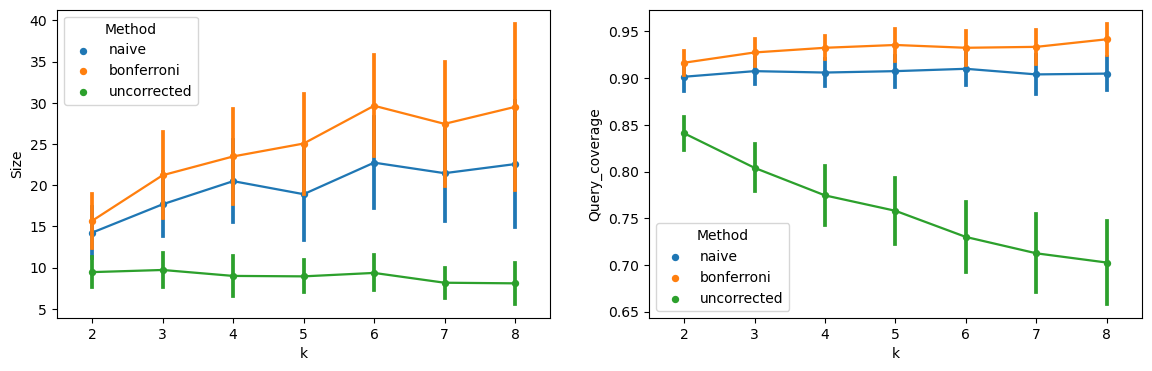

In [110]:
# Make plot
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

sns.pointplot(data=results, x="k", y="Size", hue='Method', estimator='median', errorbar='sd', scale=0.6, ax=ax[0])
sns.pointplot(data=results, x="k", y="Query_coverage", hue='Method', estimator='median', errorbar='sd', ax=ax[1], scale=0.6)

plt.show()

In [143]:
mu = 30

#####################
#  Run Experiments  #
#####################
results = pd.DataFrame({})

for k in tqdm(k_list, desc="Size k", leave=True, position=0):
    for i in tqdm(range(repetition), desc="Repetitions", leave=True, position=0):
        random_state = repetition * seed + i
        size_obs = n1 * n2 * prob_obs
        n_calib_queries = int(size_obs//(2*k))
        
        res = run_single_experiment(M_true, alpha, k, size_obs, n_calib_queries, max_test_queries, 
                          r_true, r_guess, gamma_n=gamma_n, gamma_m=gamma_m, noise_model=noise_model, a=a, b=b, mu=mu,
                          random_state=random_state)

        results = pd.concat([results, res])

add_header(results)

Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<01:40,  2.04s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:46,  2.21s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:06<01:46,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:08<01:44,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:11<01:42,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:13<01:40,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:15<01:35,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:17<01:34,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:20<01:34,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:22<01:30,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:25<01:35,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:27<01:30,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:29<01:26,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:32<01:24,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:34<01:22,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:37<01:25,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:40<01:24,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:42<01:22,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:45<01:18,  2.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:47<01:14,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:50<01:11,  2.46s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:52<01:08,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:54<01:03,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:56<01:01,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [00:59<00:58,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:01<00:55,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:03<00:52,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:06<00:50,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:08<00:47,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:10<00:45,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:12<00:43,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:15<00:40,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:17<00:37,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:19<00:37,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:22<00:35,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:24<00:33,  2.40s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:27<00:31,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:30<00:31,  2.60s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:32<00:28,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:35<00:25,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:37<00:23,  2.60s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:40<00:19,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:42<00:17,  2.46s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:44<00:14,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:47<00:12,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:49<00:09,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:52<00:07,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:55<00:05,  2.56s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [01:57<00:02,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  14%|██████████▋                                                                | 1/7 [01:59<11:57, 119.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<01:49,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:46,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:06<01:47,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:09<01:44,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:11<01:44,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:13<01:40,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:15<01:37,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:18<01:33,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:20<01:30,  2.21s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:22<01:31,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:24<01:28,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:27<01:26,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:29<01:23,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:31<01:20,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:33<01:18,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:36<01:17,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:38<01:16,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:40<01:13,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:43<01:12,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:45<01:10,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:48<01:08,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:50<01:05,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:52<01:02,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:54<00:59,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [00:57<00:57,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [00:59<00:55,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:01<00:52,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:03<00:50,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:06<00:48,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:08<00:45,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:10<00:43,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:13<00:40,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:15<00:38,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:17<00:36,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:19<00:33,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:22<00:32,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:24<00:29,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:26<00:26,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:28<00:24,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:30<00:22,  2.21s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:33<00:20,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:35<00:17,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:37<00:15,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:40<00:13,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:42<00:11,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:44<00:09,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:46<00:06,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:48<00:04,  2.22s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [01:51<00:02,  2.22s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  29%|█████████████████████▍                                                     | 2/7 [03:52<09:39, 115.95s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.30000000000000004 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<01:51,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:48,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:06<01:45,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:08<01:42,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:11<01:39,  2.21s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:13<01:39,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:15<01:36,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:17<01:33,  2.22s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:20<01:31,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:22<01:29,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:24<01:27,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:27<01:27,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:29<01:24,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:31<01:22,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:33<01:20,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:36<01:17,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:38<01:15,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:40<01:12,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:43<01:11,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:45<01:08,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:47<01:06,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:49<01:03,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:52<01:01,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:54<00:58,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [00:56<00:57,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [00:59<00:54,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:01<00:53,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:03<00:51,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:06<00:48,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:08<00:45,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:10<00:43,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:12<00:40,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:15<00:40,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:17<00:38,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:20<00:37,  2.51s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:23<00:35,  2.51s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:25<00:32,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:28<00:30,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:30<00:28,  2.56s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:33<00:26,  2.66s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:36<00:23,  2.62s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:38<00:20,  2.54s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:41<00:17,  2.54s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:43<00:15,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:46<00:12,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:48<00:09,  2.43s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:50<00:07,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:52<00:04,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [01:55<00:02,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  43%|████████████████████████████████▏                                          | 3/7 [05:50<07:46, 116.70s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.4 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<02:01,  2.48s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:59,  2.48s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:07<01:57,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:09<01:52,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:12<01:50,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:14<01:48,  2.47s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:17<01:50,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:20<01:46,  2.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:22<01:43,  2.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:25<01:40,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:27<01:36,  2.48s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:29<01:34,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:32<01:32,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:36<01:41,  2.81s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:39<01:40,  2.88s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:41<01:34,  2.78s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:44<01:31,  2.77s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:47<01:28,  2.77s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:49<01:23,  2.69s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:52<01:21,  2.73s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:55<01:17,  2.68s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:57<01:15,  2.69s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [01:00<01:11,  2.66s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [01:02<01:08,  2.63s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [01:05<01:04,  2.59s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:07<01:01,  2.56s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:10<00:59,  2.58s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:13<00:56,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:15<00:54,  2.59s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:17<00:50,  2.51s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:21<00:52,  2.75s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:24<00:50,  2.80s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:26<00:47,  2.78s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:29<00:43,  2.69s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:31<00:39,  2.64s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:34<00:37,  2.70s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:37<00:36,  2.79s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:40<00:32,  2.71s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:42<00:29,  2.65s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:45<00:25,  2.55s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:47<00:22,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:50<00:20,  2.51s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:52<00:17,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:54<00:14,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:57<00:12,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [02:00<00:10,  2.68s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [02:03<00:08,  2.69s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [02:05<00:05,  2.67s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [02:08<00:02,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  57%|██████████████████████████████████████████▊                                | 4/7 [08:00<06:06, 122.11s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.5 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<01:59,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:58,  2.46s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:07<02:00,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:10<02:00,  2.63s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:13<02:07,  2.84s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:16<02:05,  2.85s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:18<01:55,  2.70s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:21<01:53,  2.70s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:23<01:47,  2.61s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:26<01:41,  2.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:28<01:38,  2.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:31<01:33,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:33<01:29,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:36<01:29,  2.50s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:38<01:26,  2.48s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:41<01:24,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:43<01:21,  2.48s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:46<01:19,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:48<01:16,  2.46s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:50<01:12,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:53<01:09,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:55<01:05,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:57<01:03,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:59<01:00,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [01:02<01:03,  2.54s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:05<01:01,  2.55s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:08<00:59,  2.57s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:10<00:55,  2.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:13<00:57,  2.74s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:16<00:52,  2.62s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:19<00:51,  2.70s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:21<00:47,  2.63s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:24<00:43,  2.59s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:26<00:41,  2.59s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:29<00:39,  2.61s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:31<00:36,  2.61s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:34<00:32,  2.52s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:36<00:29,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:38<00:26,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:41<00:23,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:43<00:20,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:45<00:18,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:48<00:16,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:50<00:14,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:53<00:12,  2.51s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:56<00:10,  2.75s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:59<00:08,  2.75s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [02:01<00:05,  2.69s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [02:05<00:02,  2.83s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [10:08<04:08, 124.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.6000000000000001 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<02:02,  2.49s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:05<02:10,  2.72s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:07<02:04,  2.65s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:10<01:59,  2.60s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:12<01:53,  2.53s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:15<01:47,  2.45s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:17<01:42,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:19<01:39,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:22<01:39,  2.44s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:24<01:35,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:27<01:33,  2.39s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:29<01:29,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:31<01:26,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:33<01:22,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:36<01:20,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:38<01:18,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:40<01:16,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:42<01:13,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:45<01:11,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:47<01:11,  2.38s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:50<01:08,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:52<01:05,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:54<01:01,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:56<00:59,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [00:59<00:58,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [01:01<00:54,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:03<00:52,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:06<00:50,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:08<00:47,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:10<00:45,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:12<00:42,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:14<00:40,  2.22s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:17<00:37,  2.22s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:19<00:35,  2.20s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:21<00:32,  2.20s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:23<00:31,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:26<00:28,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:28<00:26,  2.22s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:30<00:24,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:32<00:22,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:34<00:20,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:37<00:17,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:39<00:15,  2.23s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:41<00:13,  2.24s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:43<00:11,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:46<00:09,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:48<00:06,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:50<00:04,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [01:53<00:02,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 1000 test queries...
Done!


Size k:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [12:04<02:01, 121.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.7000000000000001 for 1000 test queries...
Done!


Repetitions:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 960 test queries...
Done!


Repetitions:   2%|█▍                                                                    | 1/50 [00:02<01:56,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 960 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 960 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:   4%|██▊                                                                   | 2/50 [00:04<01:51,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:   6%|████▏                                                                 | 3/50 [00:06<01:47,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:   8%|█████▌                                                                | 4/50 [00:09<01:45,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 953 test queries...
Done!


Repetitions:  10%|███████                                                               | 5/50 [00:11<01:45,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 953 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 953 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  12%|████████▍                                                             | 6/50 [00:13<01:41,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  14%|█████████▊                                                            | 7/50 [00:16<01:39,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  16%|███████████▏                                                          | 8/50 [00:18<01:36,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  18%|████████████▌                                                         | 9/50 [00:20<01:33,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  20%|█████████████▊                                                       | 10/50 [00:22<01:30,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 961 test queries...
Done!


Repetitions:  22%|███████████████▏                                                     | 11/50 [00:25<01:28,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 961 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 961 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 952 test queries...
Done!


Repetitions:  24%|████████████████▌                                                    | 12/50 [00:27<01:26,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 952 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 952 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 961 test queries...
Done!


Repetitions:  26%|█████████████████▉                                                   | 13/50 [00:29<01:24,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 961 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 961 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  28%|███████████████████▎                                                 | 14/50 [00:32<01:24,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  30%|████████████████████▋                                                | 15/50 [00:34<01:21,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  32%|██████████████████████                                               | 16/50 [00:36<01:19,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  34%|███████████████████████▍                                             | 17/50 [00:39<01:16,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  36%|████████████████████████▊                                            | 18/50 [00:41<01:14,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  38%|██████████████████████████▏                                          | 19/50 [00:43<01:12,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  40%|███████████████████████████▌                                         | 20/50 [00:46<01:10,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  42%|████████████████████████████▉                                        | 21/50 [00:48<01:07,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  44%|██████████████████████████████▎                                      | 22/50 [00:50<01:04,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  46%|███████████████████████████████▋                                     | 23/50 [00:53<01:02,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  48%|█████████████████████████████████                                    | 24/50 [00:55<00:59,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 25/50 [00:57<00:56,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  52%|███████████████████████████████████▉                                 | 26/50 [00:59<00:54,  2.27s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  54%|█████████████████████████████████████▎                               | 27/50 [01:02<00:52,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  56%|██████████████████████████████████████▋                              | 28/50 [01:04<00:50,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  58%|████████████████████████████████████████                             | 29/50 [01:06<00:48,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 956 test queries...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 30/50 [01:09<00:47,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 956 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 956 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  62%|██████████████████████████████████████████▊                          | 31/50 [01:11<00:46,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  64%|████████████████████████████████████████████▏                        | 32/50 [01:14<00:43,  2.42s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  66%|█████████████████████████████████████████████▌                       | 33/50 [01:16<00:40,  2.41s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  68%|██████████████████████████████████████████████▉                      | 34/50 [01:18<00:37,  2.37s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 953 test queries...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 35/50 [01:21<00:35,  2.34s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 953 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 953 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  72%|█████████████████████████████████████████████████▋                   | 36/50 [01:23<00:32,  2.36s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 957 test queries...
Done!


Repetitions:  74%|███████████████████████████████████████████████████                  | 37/50 [01:25<00:30,  2.35s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 957 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 957 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  76%|████████████████████████████████████████████████████▍                | 38/50 [01:28<00:27,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 956 test queries...
Done!


Repetitions:  78%|█████████████████████████████████████████████████████▊               | 39/50 [01:30<00:25,  2.33s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 956 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 956 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 40/50 [01:32<00:22,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 962 test queries...
Done!


Repetitions:  82%|████████████████████████████████████████████████████████▌            | 41/50 [01:35<00:20,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 962 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 962 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 954 test queries...
Done!


Repetitions:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [01:37<00:18,  2.29s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 954 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 954 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 961 test queries...
Done!


Repetitions:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [01:39<00:15,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 961 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 961 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [01:41<00:13,  2.25s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 958 test queries...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 45/50 [01:44<00:11,  2.26s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 958 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 958 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 953 test queries...
Done!


Repetitions:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [01:46<00:09,  2.30s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 953 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 953 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 955 test queries...
Done!


Repetitions:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [01:48<00:06,  2.31s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 955 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 955 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 959 test queries...
Done!


Repetitions:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [01:51<00:04,  2.32s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 959 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 959 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 956 test queries...
Done!


Repetitions:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [01:53<00:02,  2.28s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 956 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 956 test queries...
Done!
Running matrix completion algorithm on the splitted training set...
Done training!

Computing naive prediction intervals for 956 test queries...
Done!


Size k: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [14:00<00:00, 120.03s/it]

Computing prediction intervals with Bonferroni correction with alpha 0.1 for 956 test queries...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.8 for 956 test queries...
Done!


,Query_coverage,Coverage,Size,Inf_prop,Method,k,Calib_size,Train_size,Test_size,random_state,n1,n2,alpha,r_true,r_guess,gamma_n,gamma_m,noise_model,mu
0,0.900000,0.932000,24.615891,0.0,naive,2,500,1000,1000,50,100,100,0.1,3,3,0.5,0.9,step,30
0,0.919000,0.945000,31.927115,0.0,bonferroni,2,500,1000,1000,50,100,100,0.1,3,3,0.5,0.9,step,30
0,0.841000,0.888500,14.823095,0.0,uncorrected,2,500,1000,1000,50,100,100,0.1,3,3,0.5,0.9,step,30
0,0.911000,0.943500,18.046443,0.0,naive,2,500,1000,1000,51,100,100,0.1,3,3,0.5,0.9,step,30
0,0.928000,0.952500,21.258944,0.0,bonferroni,2,500,1000,1000,51,100,100,0.1,3,3,0.5,0.9,step,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.947699,0.990717,79.082220,0.0,bonferroni,8,125,1000,956,98,100,100,0.1,3,3,0.5,0.9,step,30
0,0.820084,0.903373,15.387778,0.0,uncorrected,8,125,1000,956,98,100,100,0.1,3,3,0.5,0.9,step,30
0,0.899582,0.948353,15.598446,0.0,naive,8,125,1000,956,99,100,100,0.1,3,3,0.5,0.9,step,30
0,0.949791,0.988363,51.787757,0.0,bonferroni,8,125,1000,956,99,100,100,0.1,3,3,0.5,0.9,step,30


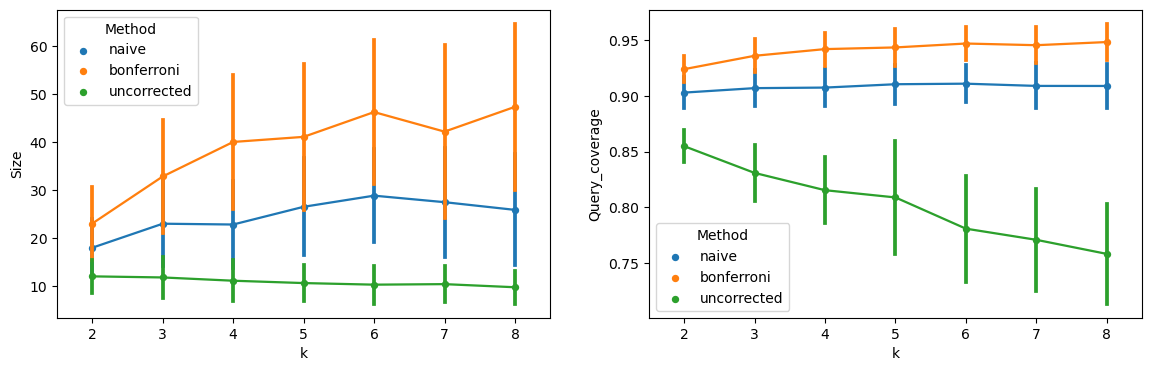

In [144]:
# Make plot
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

sns.pointplot(data=results, x="k", y="Size", hue='Method', estimator='median', errorbar='sd', scale=0.6, ax=ax[0])
sns.pointplot(data=results, x="k", y="Query_coverage", hue='Method', estimator='median', errorbar='sd', ax=ax[1], scale=0.6)

plt.show()

In [243]:
test = pd.DataFrame({})

In [244]:
a_list=[0.1, 0.2]

In [245]:
test["alpha"]=a_list

In [246]:
test["upper"]=[[1,2,3,4] for i in range(2)]

In [247]:
test

,alpha,upper
0,0.1,"[1, 2, 3, 4]"
1,0.2,"[1, 2, 3, 4]"


In [255]:
test.loc[1,'upper'][2:4]=[9,9]

In [252]:
test

,alpha,upper
0,0.1,"[1, 2, 3, 4]"
1,0.2,"[9, 9, 9, 9]"


In [176]:
a_list=np.asarray(alpha).reshape(-1)

In [257]:
test.alpha=[0,2]

In [258]:
test

,alpha,upper
0,0,"[1, 2, 3, 4]"
1,2,"[9, 9, 9, 9]"


In [177]:
a_list

array([0.1, 0.4])

In [180]:
test = [[1,2],[3,4]]
test

[[1, 2], [3, 4]]

In [184]:
np.array(test).shape

(2, 2)

In [186]:
test = np.asarray(1)

[autoreload of methods failed: Traceback (most recent call last):
  File "C:\Users\16266\anaconda3\envs\cmc\lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\16266\anaconda3\envs\cmc\lib\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
  File "C:\Users\16266\anaconda3\envs\cmc\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\16266\Documents\GitHub\conformal-matrix-completion\notebooks\../smc\methods.py", line 324
    if w_type.shape != self.Mhat.s

In [7]:
np.min([3,0,1])

0